<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 3)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. **Description**:
   - **Idea**: k-mer Representation with position analysis 
   - Break the DNA sequence into k-mers.
   - Use embeddings to represent each k-mer, capturing more complex relationships and context.
   - Train a model using these embeddings.

2. **Pros**:
   - Captures richer contextual information through embeddings.
   - Can capture long-range dependencies if using advanced embedding techniques (e.g., BERT).

3. **Cons**:
   - More complex and computationally intensive.
   - Requires large amounts of data to train effective embeddings.

    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Dense, GlobalAveragePooling1D, Embedding, MultiHeadAttention, Flatten
from tensorflow.keras.layers import MaxPool1D, Dropout, LayerNormalization, MaxPooling1D, Input
from tensorflow.keras.models import Sequential, Model
from keras.layers import LSTM, SimpleRNN

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF

# Metric and utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# Warning
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print(gpu_devices)
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

[]


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [2]:
dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
dataset.head()

,id,sequence,length,class
0,AT1G51140.1,AAGTTTCTCTCACGTTCTCTTTTTTAATTTTAATTTCTCGCCGGAA...,2297,0
1,AT1G73830.1,ACTTTCTATTTTCACCAATTTTCAAAAAAAAAATAAAAATTGAAAC...,1473,0
2,AT1G09530.1,AGTTACAGACGATTTGGTCCCCTCTCTTCTCTCTCTGCGTCCGTCT...,2958,0
3,AT1G49770.1,ATGACTAATGCTCAAGAGTTGGGGCAAGAGGGTTTTATGTGGGGCA...,2205,0
4,AT1G68810.1,AAACTTTTGTCTCTTTTTAACTCTCTTAACTTTCGTTTCTTCTCCT...,1998,0


### 3 - Preprocessing
Instead of taking each base as an individual token, we tokenized DNA sequences using the k-mer representation, a widely adopted method in DNA sequence analysis. The k-mer approach captures richer contextual information for each nucleotide by concatenating it with its subsequent bases to form k-mers. For example, the DNA sequence ‘ATGCCA’ can be tokenized into four 3-mers: "ATG, TGC, GCC, CCA", or into three 4-mers: "ATGC, TGCC, GCCA". In our experiments, we will try these k-mer length: 3, 4, 5, and 6.

In [3]:
def seq2kmer(sequence, k=3, step=1, as_sentence=False):
    kmer_list = []
    for i in range(0, len(sequence) - k + 1, step):
        kmer_list.append(sequence[i:i + k])
    if as_sentence:
        kmer_list = " ".join(kmer_list)
    return kmer_list

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [4]:
k = 3
kmer_sequences = dataset['sequence'].apply(lambda seq: seq2kmer(seq, k=k))
kmer_sequences.head()

0    [AAG, AGT, GTT, TTT, TTC, TCT, CTC, TCT, CTC, ...
1    [ACT, CTT, TTT, TTC, TCT, CTA, TAT, ATT, TTT, ...
2    [AGT, GTT, TTA, TAC, ACA, CAG, AGA, GAC, ACG, ...
3    [ATG, TGA, GAC, ACT, CTA, TAA, AAT, ATG, TGC, ...
4    [AAA, AAC, ACT, CTT, TTT, TTT, TTG, TGT, GTC, ...
Name: sequence, dtype: object

- Tokenization

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(kmer_sequences)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)
print("Found {} unique tokens".format(VOCAB_SIZE))

Found 64 unique tokens


In [6]:
X = tokenizer.texts_to_sequences(kmer_sequences)
X[0][:20]

[5, 31, 16, 1, 8, 4, 27, 4, 27, 15, 48, 55, 56, 16, 8, 4, 27, 4, 9, 1]

In [7]:
y = dataset['class']
max_seq_length = max([len(seq) for seq in X])
max_seq_length

4871

In [8]:
PAD_LENGTH = max_seq_length
NUM_CLASSES = 1

* Padding

In [9]:
X_padded = pad_sequences(X, maxlen=PAD_LENGTH)
X_padded.shape, y.shape

((380, 4871), (380,))

* Split into train and testset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, train_size=0.9, stratify=y)

print("Shapes of train/test splits:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (342, 4871)
X_test: (38, 4871)
y_train: (342,)
y_test: (38,)


### 4 - Model Utils

In [11]:
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/A4/Weights/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], '.-', label=m, lw=2, )
    plt.legend()

### 5 - Training and Testing

#### 5.1 MODEL 1 : FEED-FORWARD NETWORKS WITHOUT EMBEDDINGS

In [12]:
name="FF_k{}_E0".format(k)
def feedforward_net1(num_class=NUM_CLASSES, seq_length=PAD_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(seq_length,)))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(num_class, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "FF_k3_E0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 250)            │     1,218,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,218,251 (4.65 MB)

 Trainable params: 1,218,251 (4.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5681 - loss: 81.9481 - val_accuracy: 0.5429 - val_loss: 7.1900
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5765 - loss: 14.4207 - val_accuracy: 0.5429 - val_loss: 8.0877
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5648 - loss: 7.1827 - val_accuracy: 0.5429 - val_loss: 1.9554
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5835 - loss: 1.8031 - val_accuracy: 0.5429 - val_loss: 1.1714
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5967 - loss: 1.3996 - val_accuracy: 0.5429 - val_loss: 1.5404
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5804 - loss: 1.0569 - val_accuracy: 0.5429 - val_loss: 1.0951
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5934 - loss: 0.6938 - val_accuracy: 0.5429 - val_loss: 1.1250
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5607 - loss: 0.6769 - val_accuracy: 0.5429 - val_loss: 0.841

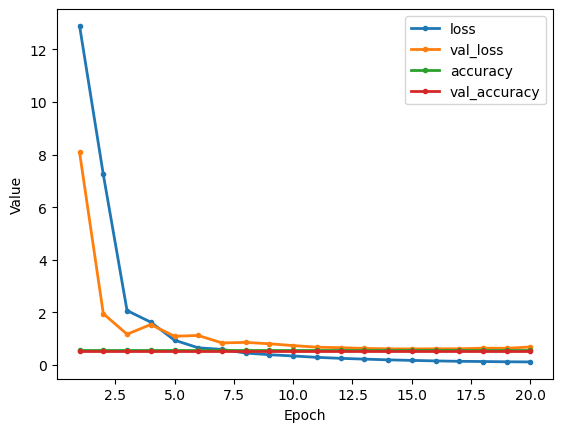

In [13]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 5.1 MODEL 1-1 : FEED-FORWARD NETWORKS WITH EMBEDDINGS

In [165]:
embedding_dim   = 50
vocabulary_size = VOCAB_SIZE+1
name="FF_k{}_E1".format(k)
def feedforward_net2(num_class=NUM_CLASSES):
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(Flatten())
    #model.add(Dense(250, activation='relu'))
    model.add(Dense(num_class, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net2()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "FF_k3_E1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 4871, 50)       │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 243550)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │       243,551 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,801 (964.07 KB)

 Trainable params: 246,801 (964.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5351 - loss: 0.9916 - val_accuracy: 0.4286 - val_loss: 0.7421
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4943 - loss: 0.6675 - val_accuracy: 0.6000 - val_loss: 0.6578
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8730 - loss: 0.4337 - val_accuracy: 0.5714 - val_loss: 0.7138
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9156 - loss: 0.2857 - val_accuracy: 0.7143 - val_loss: 0.6044
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9961 - loss: 0.1716 - val_accuracy: 0.5714 - val_loss: 0.6297
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9935 - loss: 0.0927 - val_accuracy: 0.5429 - val_loss: 0.5767
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9983 - loss: 0.0471 - val_accuracy: 0.7429 - val_loss: 0.5485
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0251 - val_accuracy: 0.5429 - val_loss: 0.6005


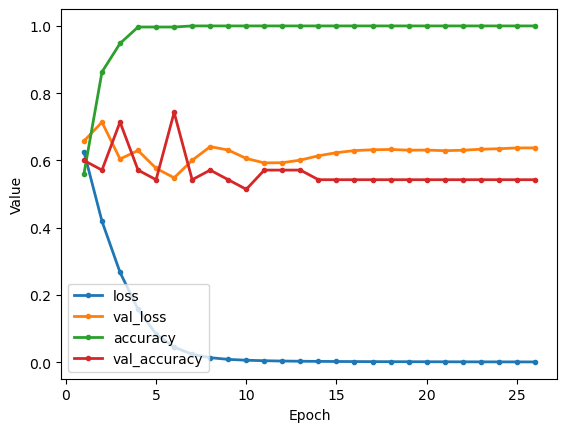

In [166]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 5.2 MODEL 2 : CONVOLUTIONAL NEURAL NETWORKS (CNN)
DNA sequence can be thought of as 1-dimensional sequence (a single, long vector) and we can apply 1D Convolutions.

In [169]:
embedding_dim   = 50
vocabulary_size = VOCAB_SIZE+1
name="CNN_k{}_E1".format(k)
def cnn(layers=2, filters=[32, 64, 128], kernel_size=3, num_class=NUM_CLASSES):
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    for i in range(layers):
        model.add(Conv1D(filters=filters[i], kernel_size=kernel_size, activation='relu'))
        model.add(MaxPool1D(pool_size=2, strides=2))
    #model.add(Flatten())
    model.add(GlobalAveragePooling1D())
    #model.add(Dense(250, activation='relu'))
    model.add(Dense(num_class, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = cnn(layers=1)
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "CNN_k3_E1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 4871, 50)       │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 4869, 32)       │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 2434, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,115 (31.70 KB)

 Trainable params: 8,115 (31.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5847 - loss: 0.6883 - val_accuracy: 0.5652 - val_loss: 0.6871
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5884 - loss: 0.6780 - val_accuracy: 0.5652 - val_loss: 0.6841
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5348 - loss: 0.6925 - val_accuracy: 0.5652 - val_loss: 0.6834
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6034 - loss: 0.6772 - val_accuracy: 0.5652 - val_loss: 0.6868
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5847 - loss: 0.6772 - val_accuracy: 0.5652 - val_loss: 0.6816
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5721 - loss: 0.6784 - val_accuracy: 0.5652 - val_loss: 0.6790
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5587 - loss: 0.6810 - val_accuracy: 0.5652 - val_loss: 0.6767
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5619 - loss: 0.6764 - val_accuracy: 0.5652 - val_loss: 0.6746


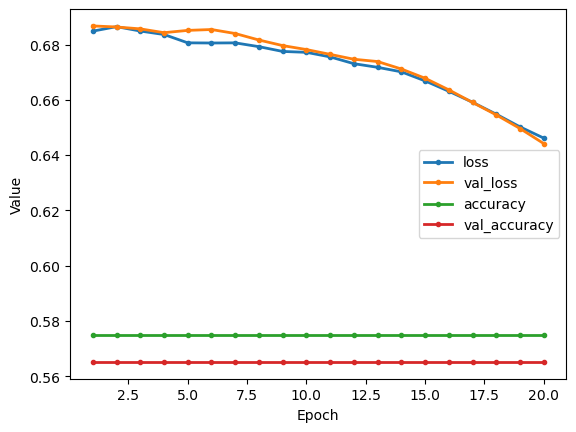

In [168]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 5.3 MODEL 3 : Simple RNN
At a high-level, an RNN is similar to a feed-forward neural network (FFNN) in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

In [172]:
embedding_dim   = 50
vocabulary_size = VOCAB_SIZE+1
name="RNN_k{}_E1".format(k)
def rnn():
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(SimpleRNN(250))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = rnn()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "RNN_k3_E1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 4871, 50)       │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 250)            │        75,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4606 - loss: 0.7065 - val_accuracy: 0.5217 - val_loss: 0.7239
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5613 - loss: 0.6866 - val_accuracy: 0.5652 - val_loss: 0.6877
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5430 - loss: 0.6910 - val_accuracy: 0.5652 - val_loss: 0.6847
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5535 - loss: 0.6815 - val_accuracy: 0.5652 - val_loss: 0.6864
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5741 - loss: 0.6787 - val_accuracy: 0.5652 - val_loss: 0.6956
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5977 - loss: 0.6701 - val_accuracy: 0.5652 - val_loss: 0.6861
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5830 - loss: 0.6701 - val_accuracy: 0.5652 - val_loss: 0.6835
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5897 - loss: 0.6686 - val_accuracy: 0.5652 - val_loss: 0.6833
Epoch 9/

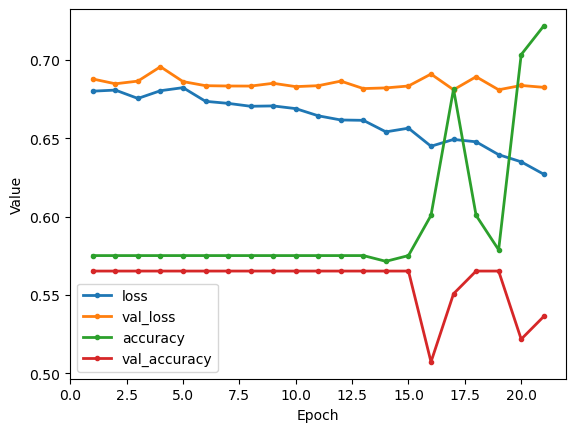

In [173]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 5.4 MODEL 4 : LSTM
At a high-level, an RNN is similar to a feed-forward neural network (FFNN) in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

In [174]:
embedding_dim   = 50
vocabulary_size = VOCAB_SIZE+1
name="LSTM_k{}_E1".format(k)
def sltm():
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = sltm()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "LSTM_k3_E1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 4871, 50)       │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,751 (249.03 KB)

 Trainable params: 63,751 (249.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.4971 - loss: 0.6918 - val_accuracy: 0.5652 - val_loss: 0.6879
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5667 - loss: 0.6836 - val_accuracy: 0.5652 - val_loss: 0.6864
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5930 - loss: 0.6750 - val_accuracy: 0.5652 - val_loss: 0.6893
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5749 - loss: 0.6764 - val_accuracy: 0.5652 - val_loss: 0.6860
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5953 - loss: 0.6628 - val_accuracy: 0.5652 - val_loss: 0.6852
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5869 - loss: 0.6637 - val_accuracy: 0.5507 - val_loss: 0.6855
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6139 - loss: 0.6549 - val_accuracy: 0.5652 - val_loss: 0.6868
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6301 - loss: 0.6488 - val_accuracy: 0.5507 - val_loss: 0.6917
Epoch 9/

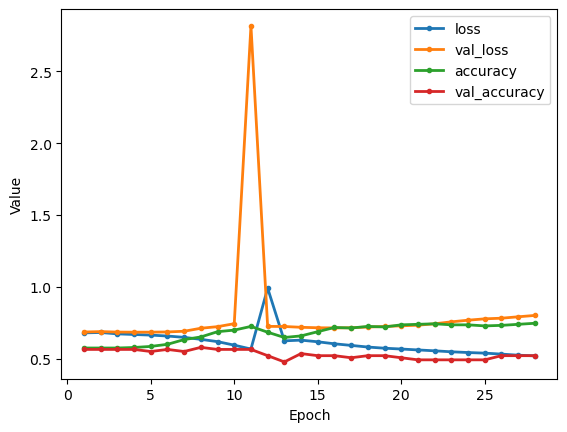

In [175]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 5.5 MODEL 5 : CNN + LSTM
CNNs are good at learning spatial features, and sentences can be thought of as 1-D spatial vectors (dimensionality is determined by the number of words in the sentence). We apply an LSTM over the features learned by the CNN (after a maxpooling layer). This leverages the power of CNNs and LSTMs combined! We expect the CNN to be able to pick out invariant features across the 1-D spatial structure (i.e., sentence) that characterize 1 and 0 classes. This learned spatial features may then be learned as sequences by an LSTM layer, and the final classification can be made via a feed-forward connection to a single node.

In [176]:
embedding_dim   = 50
vocabulary_size = VOCAB_SIZE+1
name="CNNLSTM_k{}_E1".format(k)
def cnn_lstm():
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = cnn_lstm()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "CNNLSTM_k3_E1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 4871, 50)       │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 4871, 32)       │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 2435, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,383 (239.78 KB)

 Trainable params: 61,383 (239.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5699 - loss: 0.6909 - val_accuracy: 0.5652 - val_loss: 0.6859
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5663 - loss: 0.6835 - val_accuracy: 0.5652 - val_loss: 0.6849
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5669 - loss: 0.6810 - val_accuracy: 0.5652 - val_loss: 0.6865
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5851 - loss: 0.6737 - val_accuracy: 0.5652 - val_loss: 0.6863
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5747 - loss: 0.6743 - val_accuracy: 0.5652 - val_loss: 0.6838
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5667 - loss: 0.6742 - val_accuracy: 0.5652 - val_loss: 0.6838
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5845 - loss: 0.6664 - val_accuracy: 0.5652 - val_loss: 0.6832
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6023 - loss: 0.6549 - val_accuracy: 0.5652 - val_loss: 0.6834
Epoch 9/30
5/5 ━

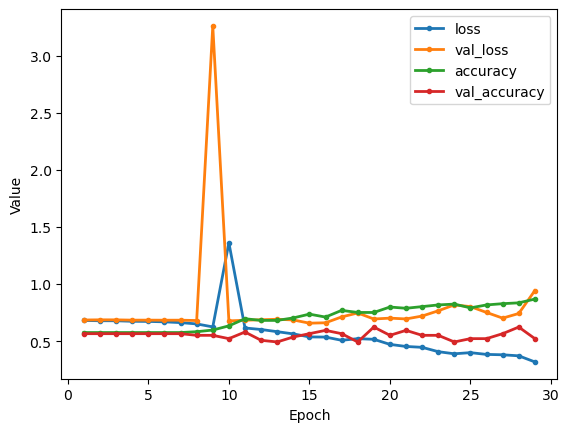

In [177]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 5.6 MODEL 5 : FF + DNABERT

In [100]:
# Utils
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
import torch

def load_pretrained_model(name, num_classes):
    global model, device, tokenizer

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        device = torch.device("cuda:0")
        print("Running the model on CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Running the model on M1 CPU")
    else:
        print("Running the model on CPU")

    tokenizer = AutoTokenizer.from_pretrained(name, do_lower_case=False)
    model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=num_classes)
    model.to(device)

    return model, tokenizer, device

* As we are going to use pretrained model for tokenization and embedding let get initial dataset and split before

In [101]:
X_train, X_test, y_train, y_test = train_test_split(dataset['sequence'], dataset['class'], train_size=0.9, stratify=y)

print("Shapes of train/test splits:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (342,)
X_test: (38,)
y_train: (342,)
y_test: (38,)


* From DNA seqeucne to kmer format

In [102]:
X_train_kmer = X_train.apply(lambda seq: seq2kmer(seq, k=k, as_sentence=True))
X_test_kmer  = X_test.apply(lambda seq: seq2kmer(seq, k=k, as_sentence=True))
X_train_kmer = X_train_kmer.tolist()
X_test_kmer  = X_test_kmer.tolist()

* load pretrained model

In [103]:
model, tokenizer, device = load_pretrained_model("zhihan1996/DNA_bert_"+str(k), NUM_CLASSES)

Running the model on M1 CPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNA_bert_3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* from kmer to number

In [104]:
X_train = tokenizer.batch_encode_plus(
    X_train_kmer,
    max_length=max_seq_length,
    padding=True,
    truncation=True,
    return_attention_mask=False,
    return_tensors="np",#pt
)
X_test = tokenizer.batch_encode_plus(
    X_test_kmer,
    max_length=max_seq_length,
    padding=True,
    truncation=True,
    return_attention_mask=False,
    return_tensors="np",#pt
)

In [105]:
X_train['input_ids']

array([[ 2, 38,  9, ...,  0,  0,  0],
       [ 2, 12, 33, ...,  0,  0,  0],
       [ 2, 60, 36, ...,  0,  0,  0],
       ...,
       [ 2, 35, 63, ...,  0,  0,  0],
       [ 2, 12, 33, ...,  0,  0,  0],
       [ 2,  7, 13, ...,  0,  0,  0]])

In [115]:
#import wandb
from transformers import Trainer, TrainingArguments
from pathlib import Path

In [121]:
results_dir = Path("./Results/Classification/")
results_dir.mkdir(parents=True, exist_ok=True)
EPOCHS = 10
BATCH_SIZE = 8

# initialize wandb for logging the training process
#wandb.init(project="DNA_bert", name="zhihan1996/DNA_bert_"+str(k))
#wandb.config.update(model_config)

training_args = TrainingArguments(
    output_dir=results_dir / "checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # L2 regularization lambda value
    logging_steps=60,  # log metrics every 60 steps
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
# save the model and tokenizer
model_path = results_dir / "model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

In [119]:
!pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 1.9 MB/s eta 0:00:0000:0100:01


In [87]:
embedding_dim   = 50
vocabulary_size = VOCAB_SIZE+1
name="FF_k{}_E1".format(k)
def feedforward_net2(num_class=NUM_CLASSES):
    model = Sequential(name=name)
    model.add(Input(shape=(max_seq_length,)))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim))
    model.add(Flatten())
    model.add(Dense(num_class, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net2()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

history = model.fit(X_train['input_ids'], y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[])

# Evaluate and score
scores = model.evaluate(X_test['input_ids'], y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "FF_k3_E1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 4871, 50)       │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 243550)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │       243,551 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,801 (964.07 KB)

 Trainable params: 246,801 (964.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5154 - loss: 0.8308 - val_accuracy: 0.4058 - val_loss: 0.8253
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6129 - loss: 0.5813 - val_accuracy: 0.6957 - val_loss: 0.5946
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9336 - loss: 0.3710 - val_accuracy: 0.7101 - val_loss: 0.5647
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9243 - loss: 0.2593 - val_accuracy: 0.6957 - val_loss: 0.5553
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9887 - loss: 0.1500 - val_accuracy: 0.6812 - val_loss: 0.5379
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9934 - loss: 0.0769 - val_accuracy: 0.6812 - val_loss: 0.5410
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9934 - loss: 0.0444 - val_accuracy: 0.6957 - val_loss: 0.5413
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 0.6957 - val_loss: 0.5419


2024-05-22 05:12:15.957788: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-05-22 05:12:15.958530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
	 [[{{node FF_k3_E1_1/flatten_2_1/Reshape}}]]


InvalidArgumentError: Graph execution error:

Detected at node FF_k3_E1_1/flatten_2_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T/ipykernel_3621/4255882788.py", line 22, in <module>

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 441, in evaluate

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 170, in one_step_on_iterator

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 158, in one_step_on_data

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 84, in test_step

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py", line 826, in __call__

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/sequential.py", line 206, in call

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py", line 199, in call

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/function.py", line 151, in _run_through_graph

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py", line 583, in call

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py", line 826, in __call__

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 4527, in reshape

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1618, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node FF_k3_E1_1/flatten_2_1/Reshape}}]] [Op:__inference_one_step_on_iterator_18362]

Running the model on M1 CPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNA_bert_3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Load model
PRETRAINED=f"zhihan1996/DNA_bert_{k}"
pipe = pipeline("fill-mask", model=PRETRAINED)
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)
model = AutoModelForMaskedLM.from_pretrained(PRETRAINED)

Some weights of the model checkpoint at zhihan1996/DNA_bert_3 were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at zhihan1996/DNA_bert_3 were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fro

In [184]:
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.8 MB/s eta 0:00:00a 0:00:01
